# Model Development and Evaluation

### Import the required libraries and packages 
*Import the preprocessed dataset, set device to use GPU if CUDA is available*

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, 
                             accuracy_score, precision_score, recall_score, f1_score)

df = pd.read_csv('cleaned_reviews.csv')

# Set device to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### The initial dataset is split into small, medium, and large sizes
*After this, the resulting datasets are split into training and testing subsets*

In [20]:
# Shuffle the dataset for randomness
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

def split_dataset(df):
    return train_test_split(
        df, test_size=0.2, stratify=df['sentiment'], random_state=42
    )


# Define datasets
small_dataset = df[:500]
medium_dataset = df[:1000]
large_dataset = df[:10000]

train_small, test_small = split_dataset(small_dataset)
train_medium, test_medium = split_dataset(medium_dataset)
train_large, test_large = split_dataset(large_dataset)


### The datasets are tokenized using DistilBERT's tokenizer

In [21]:
# Load tokenizer
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint, model_max_length=128)

# Tokenization function
def tokenize_data(df):
    return tokenizer(
        list(df['review']),
        truncation=True,
        padding=True,
        return_tensors="pt"
    )
    
    return {key: list(val) for key, val in encoded.items()}


# Tokenize datasets
tokenized_train_small = tokenize_data(train_small)
tokenized_test_small = tokenize_data(test_small)

tokenized_train_medium = tokenize_data(train_medium)
tokenized_test_medium = tokenize_data(test_medium)

tokenized_train_large = tokenize_data(train_large)
tokenized_test_large = tokenize_data(test_large)


# Convert datasets to PyTorch dataset objects
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer):
        self.reviews = df["review"].tolist()
        self.labels = df["sentiment"].tolist()
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        encodings = self.tokenizer(
            self.reviews[idx],
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )
        item = {key: val.squeeze(0) for key, val in encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item


# Prepare the datasets
train_dataset_small = SentimentDataset(train_small, tokenizer)
test_dataset_small = SentimentDataset(test_small, tokenizer)

train_dataset_medium = SentimentDataset(train_medium, tokenizer)
test_dataset_medium = SentimentDataset(test_medium, tokenizer)

train_dataset_large = SentimentDataset(train_large, tokenizer)
test_dataset_large = SentimentDataset(test_large, tokenizer)


### Initializing DistilBERT model

In [22]:
# Load the model
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

### Training and evaluating the model
*Retrieving metrics like Accuracy, Precision, Recall, F1-Score, and Confusion Matrix. Plotting the received metrics and saving the models.*

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



Training and Evaluating on Small Dataset:


/tmp/ipykernel_1644/3343679981.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.653700,0.684043,0.580000



Accuracy for Small Dataset: 0.58
Confusion Matrix for Small Dataset:
 [[16 35]
 [ 7 42]]
Classification Report for Small Dataset:
               precision    recall  f1-score   support

           0       0.70      0.31      0.43        51
           1       0.55      0.86      0.67        49

    accuracy                           0.58       100
   macro avg       0.62      0.59      0.55       100
weighted avg       0.62      0.58      0.55       100



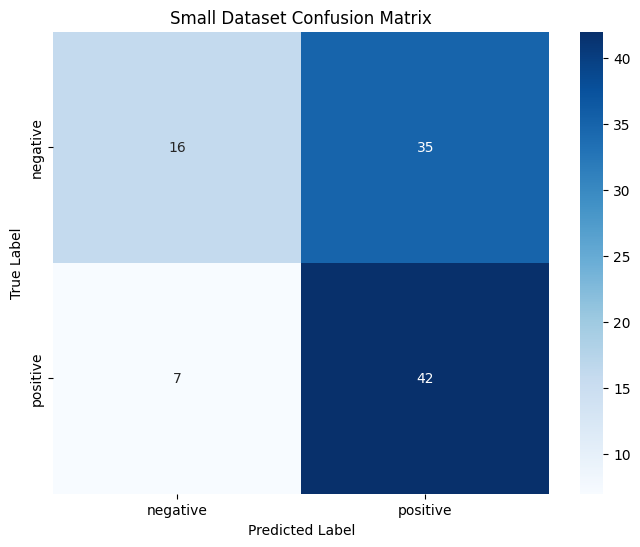


Training and Evaluating on Medium Dataset:


/tmp/ipykernel_1644/3343679981.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.453200,0.438383,0.820000



Accuracy for Medium Dataset: 0.82
Confusion Matrix for Medium Dataset:
 [[89 16]
 [20 75]]
Classification Report for Medium Dataset:
               precision    recall  f1-score   support

           0       0.82      0.85      0.83       105
           1       0.82      0.79      0.81        95

    accuracy                           0.82       200
   macro avg       0.82      0.82      0.82       200
weighted avg       0.82      0.82      0.82       200



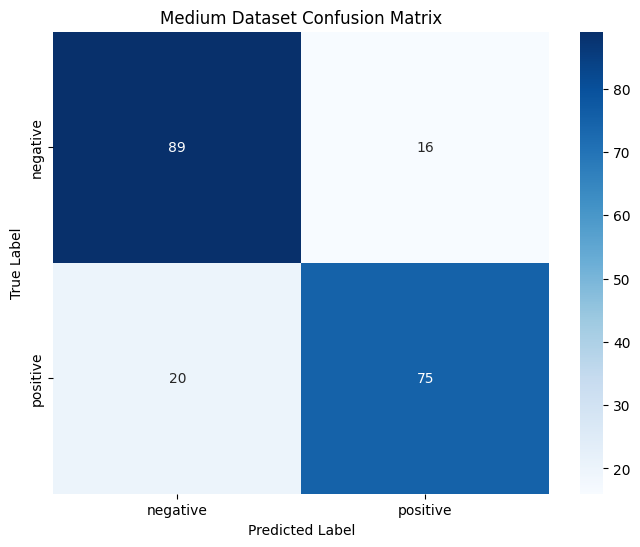


Training and Evaluating on Large Dataset:


/tmp/ipykernel_1644/3343679981.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.312600,0.325908,0.868500
2,0.243300,0.324564,0.877500



Accuracy for Large Dataset: 0.8775
Confusion Matrix for Large Dataset:
 [[852 140]
 [105 903]]
Classification Report for Large Dataset:
               precision    recall  f1-score   support

           0       0.89      0.86      0.87       992
           1       0.87      0.90      0.88      1008

    accuracy                           0.88      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000



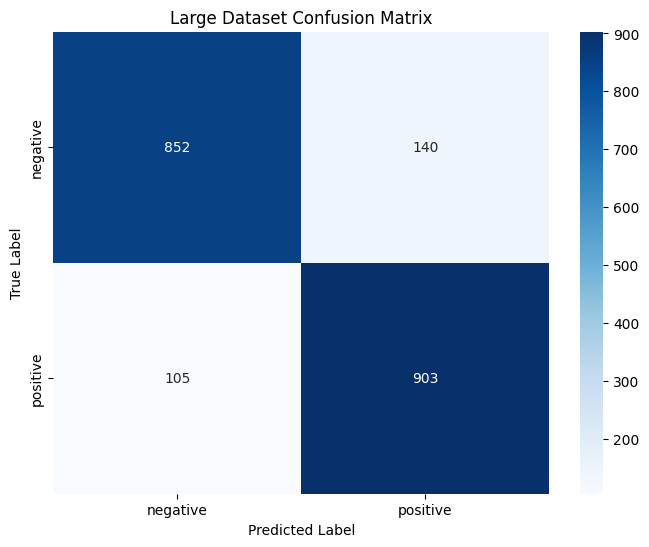

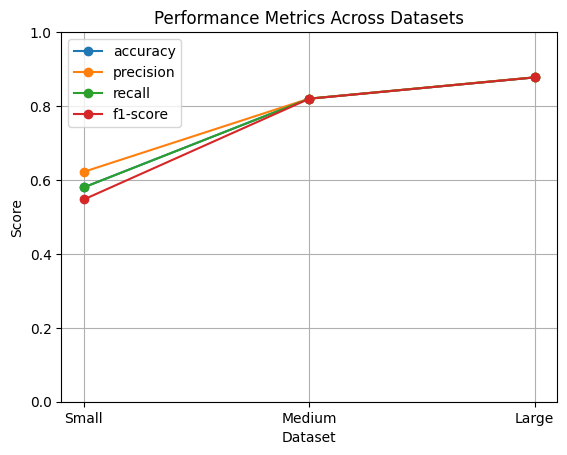

In [23]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="training_dir",
    num_train_epochs=2,
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    gradient_accumulation_steps=2,
    logging_dir="logs",
    logging_steps=10,
    save_total_limit=2,
    report_to="none",
    fp16=torch.cuda.is_available(),
)

# Define custom accuracy metric
def compute_metric(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = np.mean(predictions == labels)
    return {"accuracy": accuracy}

def train_and_evaluate(train_dataset, test_dataset):
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metric,
    )
    trainer.train()
    return trainer

def evaluate(trainer, test_dataset, dataset_name, labels):
    preds = trainer.predict(test_dataset)
    predictions = np.argmax(preds.predictions, axis=-1)

    acc = accuracy_score(test_dataset.labels, predictions)
    prec = precision_score(test_dataset.labels, predictions, average='weighted')
    rec = recall_score(test_dataset.labels, predictions, average='weighted')
    f1 = f1_score(test_dataset.labels, predictions, average='weighted')

    print(f"\nAccuracy for {dataset_name} Dataset:", acc)
    print(f"Confusion Matrix for {dataset_name} Dataset:\n", confusion_matrix(test_dataset.labels, predictions))
    print(f"Classification Report for {dataset_name} Dataset:\n", classification_report(test_dataset.labels, predictions))

    cm = confusion_matrix(test_dataset.labels, predictions)
    plot_confusion_matrix(cm, labels, f'{dataset_name} Dataset Confusion Matrix')

    return {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1-score': f1,
    }

# Confusion matrix plot
def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Plot performance metrics
def plot_metrics(metrics_dict):
    datasets = list(metrics_dict.keys())
    metrics = ['accuracy', 'precision', 'recall', 'f1-score']

    for metric in metrics:
        plt.plot(datasets, [metrics_dict[ds][metric] for ds in datasets], marker='o', label=metric)

    plt.title('Performance Metrics Across Datasets')
    plt.xlabel('Dataset')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.legend()
    plt.grid()
    plt.show()

# Train and evaluate on all datasets
def main():
    datasets = {
        'Small': (train_dataset_small, test_dataset_small),
        'Medium': (train_dataset_medium, test_dataset_medium),
        'Large': (train_dataset_large, test_dataset_large),
    }

    metrics_dict = {}

    for dataset_name, (train_data, test_data) in datasets.items():
        print(f"\nTraining and Evaluating on {dataset_name} Dataset:")
        trainer = train_and_evaluate(train_data, test_data)
        trainer.save_model(f"saved_model_{dataset_name.lower()}")
        tokenizer.save_pretrained(f"saved_model_{dataset_name.lower()}")

        metrics_dict[dataset_name] = evaluate(trainer, test_data, dataset_name, labels=["negative", "positive"])

    plot_metrics(metrics_dict)


main()

### Testing the model on custom film reviews

In [3]:
# Load the trained model for inference
sentiment_classifier = pipeline(
    "text-classification",
    model="saved_model_large",
    tokenizer="saved_model_large",
    device=0 if torch.cuda.is_available() else -1
)

# Test the model
print(sentiment_classifier("The movie was amazing, all my friends loved it!"))
print(sentiment_classifier("The movie was not so good, I found it boring."))

Device set to use cuda:0


[{'label': 'LABEL_1', 'score': 0.9589251279830933}]
[{'label': 'LABEL_0', 'score': 0.8393914699554443}]


## Testing the model to classify the overall sentiment towards the film

### Scrapping the Film Reviews from a Website
*1) The code makes a request to the website to fetch the HTML content  
2) The BeautifulSoup library is used to parse the HTML  
3) The reviews are located  
4) The desired text is extracted from the reviews*

In [14]:
from bs4 import BeautifulSoup
import requests

# List of URLs to scrape reviews from
urls = [
    'https://www.rottentomatoes.com/m/staying_alive/reviews?type=user',
    'https://www.rottentomatoes.com/m/titanic/reviews?type=user',
    'https://www.rottentomatoes.com/m/ballistic_ecks_vs_sever/reviews?type=user'
]

# Function to get reviews from a single page
def get_reviews(url):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0 Safari/537.36'
    }
    
    r = requests.get(url, headers=headers)
    soup = BeautifulSoup(r.text, 'html.parser')
    review_containers = soup.find_all('p', class_='audience-reviews__review')
    
    return [review.text.strip() for review in review_containers]


# Function to collect all reviews
def scrape_movie_reviews(base_url, max_pages=5):
    all_reviews = []
    
    for page in range(1, max_pages + 1):
        url = f"{base_url}&page={page}"
        reviews = get_reviews(url)
        
        if not reviews:
            break
            
        all_reviews.extend(reviews)
        
    return all_reviews


all_reviews = {}

for movie_url in urls:
    movie_name = movie_url.split('/')[4]
    print(f"Scraping reviews for: {movie_name}")
    reviews = scrape_movie_reviews(movie_url, max_pages=5)
    all_reviews[movie_name] = reviews
    print(f"Collected {len(reviews)} reviews for {movie_name}")

total_reviews = sum(len(revs) for revs in all_reviews.values())
print(f"\nTotal reviews collected across all movies: {total_reviews}")


Scraping reviews for: staying_alive
Collected 100 reviews for staying_alive
Scraping reviews for: titanic
Collected 100 reviews for titanic
Scraping reviews for: ballistic_ecks_vs_sever
Collected 100 reviews for ballistic_ecks_vs_sever

Total reviews collected across all movies: 300


### Determining the overall sentiment

*Classifying films as overall negatively or positively rated*

In [15]:
from transformers import pipeline
import torch
from bs4 import BeautifulSoup
import requests

# Load the sentiment classifier
sentiment_classifier = pipeline(
    "text-classification",
    model="saved_model_large",
    tokenizer="saved_model_large",
    device=0 if torch.cuda.is_available() else -1
)

# Classify reviews and determine overall movie sentiment
def classify_movie_reviews(reviews):
    positive, negative = 0, 0
    for review in reviews:
        result = sentiment_classifier(review[:512])[0]
        if result['label'] == 'LABEL_1':
            positive += 1
        elif result['label'] == 'LABEL_0':
            negative += 1
    # Determine overall sentiment
    overall_sentiment = 'Positive' if positive > negative else 'Negative'
    return overall_sentiment, positive, negative

# Main script to classify movies based on reviews
movie_sentiments = {}

for movie_url in urls:
    movie_name = movie_url.split('/')[4]  # Extract movie name from URL
    print(f"Scraping and analyzing reviews for: {movie_name}")
    reviews = scrape_movie_reviews(movie_url, max_pages=5)
    sentiment, positive_count, negative_count = classify_movie_reviews(reviews)
    movie_sentiments[movie_name] = {
        "sentiment": sentiment,
        "positive_count": positive_count,
        "negative_count": negative_count,
        "total_reviews": len(reviews)
    }

# Print results
for movie, data in movie_sentiments.items():
    print(f"\nMovie: {movie}")
    print(f"Total Reviews: {data['total_reviews']}")
    print(f"Positive Reviews: {data['positive_count']}")
    print(f"Negative Reviews: {data['negative_count']}")
    print(f"Overall Sentiment: {data['sentiment']}")

Device set to use cuda:0


Scraping and analyzing reviews for: staying_alive
Scraping and analyzing reviews for: titanic
Scraping and analyzing reviews for: ballistic_ecks_vs_sever


Token indices sequence length is longer than the specified maximum sequence length for this model (173 > 128). Running this sequence through the model will result in indexing errors



Movie: staying_alive
Total Reviews: 100
Positive Reviews: 80
Negative Reviews: 20
Overall Sentiment: Positive

Movie: titanic
Total Reviews: 100
Positive Reviews: 100
Negative Reviews: 0
Overall Sentiment: Positive

Movie: ballistic_ecks_vs_sever
Total Reviews: 100
Positive Reviews: 40
Negative Reviews: 60
Overall Sentiment: Negative
